# data loading

In [1]:
import scanpy as sc

In [2]:
adata = sc.read_h5ad('../../data/RREAE_5k_raw_integration_processed.h5ad')

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [22]:
MODELS = {'MOG': {'baseline': 'MOG CFA',
  'courses': ['non symptomatic',
   'early onset',
   'chronic peak',
   'chronic long']},
 'PLP': {'baseline': 'PLP CFA',
  'courses': ['onset I',
   'onset II',
   'peak I',
   'monophasic',
   'remitt I',
   'peak II',
   'remitt II',
   'peak III']}}

genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3','Serpina3n','Ppargc1a',"Mfn1","Mfn2","Opa1",'Sirt2']


# utilities

In [3]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

def _to_dense(X):
    return X.toarray() if sp.issparse(X) else np.asarray(X)

def get_matrix(adata, layer=None):
    if layer is None:
        return adata.X
    if layer in adata.layers:
        return adata.layers[layer]
    raise ValueError(f"Layer '{layer}' not found.")

def compute_logcpm(adata, layer=None):
    X = _to_dense(get_matrix(adata, layer))
    lib = X.sum(axis=1, keepdims=True)
    lib[lib==0] = 1
    return np.log1p((X / lib) * 1e6)

# Function to compute variability

In [10]:
def variable_genes_per_model(
    adata,
    model_name,
    MODELS,
    celltype,
    celltype_col="celltype_merged",
    course_col="course",
    counts_layer="raw",
    min_cells_per_course=20
):
    # Extract model courses
    courses = [MODELS[model_name]["baseline"]] + MODELS[model_name]["courses"]

    # Subset to celltype + model courses
    mask = (
        (adata.obs[celltype_col] == celltype)
        & (adata.obs[course_col].astype(str).isin(courses))
    )
    ad_sub = adata[mask].copy()

    # Compute logCPM
    logcpm = compute_logcpm(ad_sub, layer=counts_layer)
    logcpm_df = pd.DataFrame(logcpm, index=ad_sub.obs_names, columns=ad_sub.var_names)

    # Metadata
    meta = ad_sub.obs[[course_col]]

    # Drop tiny courses
    valid_courses = meta[course_col].value_counts()[lambda x: x >= min_cells_per_course].index
    mask = meta[course_col].isin(valid_courses)
    ad_sub = ad_sub[mask].copy()
    logcpm_df = logcpm_df.loc[mask]
    meta = meta.loc[mask]

    # Per-course mean expression
    course_means = (
        logcpm_df.assign(course=meta[course_col].values)
                 .groupby("course", observed=True).mean()
                 .T  # genes × courses
    )

    # Variability metrics
    variability = (
        course_means
        .apply(lambda x: pd.Series({
            "var": x.var(),
            "range": x.max() - x.min()
        }), axis=1)
    )

    variability = variability.sort_values("var", ascending=False)

    return course_means, variability

In [14]:
# Example for Astrocytes
for model in MODELS.keys():
    cm, var = variable_genes_per_model(
        adata,
        model_name=model,
        MODELS=MODELS,
        celltype="Astrocyte",
        celltype_col="celltype_merged",
        course_col="course",
        counts_layer="raw"
    )
    print(f"=== {model} — Top 10 variable genes in Astrocytes ===")
    print(var.head(10), "\n")

=== MOG — Top 10 variable genes in Astrocytes ===
                var     range
Serping1   3.523438  5.105893
Serpina3n  3.434820  4.951889
H2-D1      2.977234  4.375853
Irgm1      2.909134  4.422415
Irgm2      2.503805  4.103230
Oasl2      2.434132  4.140320
B2m        2.058270  3.603742
H2-K1      2.012446  3.719931
Isg15      1.822073  3.438885
Psmb8      1.779474  3.580213 



/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


=== PLP — Top 10 variable genes in Astrocytes ===
                var     range
Cd74       4.828554  5.609195
H2-D1      4.773654  5.773047
H2-K1      3.977643  5.520392
Serping1   3.948631  5.790668
Serpina3n  3.869174  6.332653
B2m        3.478288  5.017573
Irgm1      2.340053  4.861880
H2-Ab1     2.185199  4.004663
Ctss       2.178511  4.124395
C3         2.146959  4.239728 



# Plot top genes

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


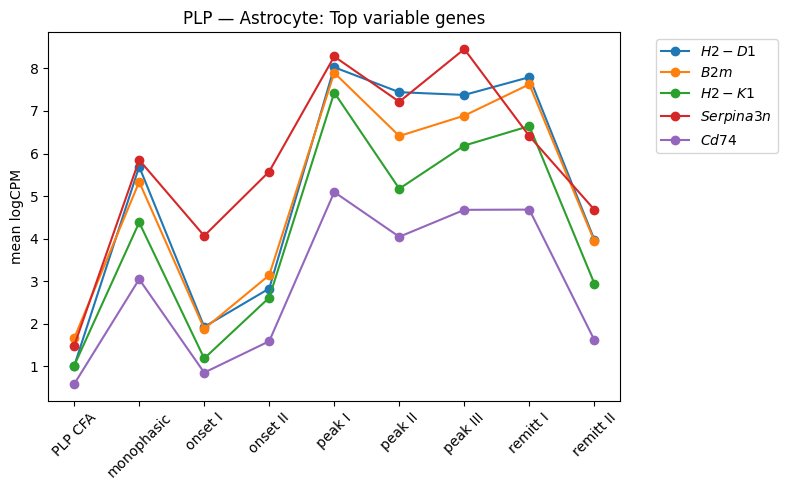

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

model = "PLP"
cm, var = variable_genes_per_model(
    adata, model_name=model, MODELS=MODELS,
    celltype="Oligodendrocyte"
)

top_genes = var.head(5).index
palette = sns.color_palette("tab10", n_colors=len(top_genes))

fig, ax = plt.subplots(figsize=(8,5))
for g, col in zip(top_genes, palette):
    ax.plot(cm.columns, cm.loc[g], marker="o", color=col, label=fr"$\it{{{g}}}$")

ax.set_ylabel("mean logCPM")
ax.set_title(f"{model} — Astrocyte: Top variable genes")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
var.head(50).index

Index(['H2-D1', 'B2m', 'H2-K1', 'Serpina3n', 'Cd74', 'C4b', 'Psmb8', 'Irgm1',
       'Plin4', 'Sgk1', 'Ctss', 'H2-T23', 'Stat1', 'Gbp7', 'Irgm2', 'Nlrc5',
       'Oasl2', 'Klk6', 'C3', 'Tap1', 'Msmo1', 'H2-Ab1', 'Klk8', 'Mt2',
       'H2-Aa', 'Spock3', 'Gfap', 'Tubb3', 'Grn', 'Serping1', 'Slc9a3r2',
       'Hmgcr', 'Lbh', 'Irf1', 'Chil1', 'Hexb', 'Igtp', 'Zbtb16', 'Gbp3',
       'Gng11', 'Irf9', 'Ldlr', 'H2-Eb1', 'Idi1', 'Stat2', 'Il33', 'Ccp110',
       'Neat1', 'Gprc5b', 'Bin1'],
      dtype='object')

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


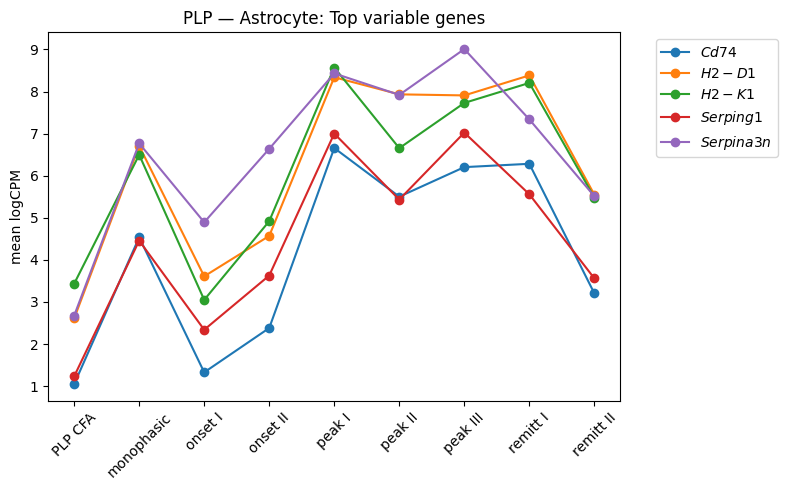

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

model = "PLP"
cm, var = variable_genes_per_model(
    adata, model_name=model, MODELS=MODELS,
    celltype="Astrocyte"
)

top_genes = var.head(5).index
palette = sns.color_palette("tab10", n_colors=len(top_genes))

fig, ax = plt.subplots(figsize=(8,5))
for g, col in zip(top_genes, palette):
    ax.plot(cm.columns, cm.loc[g], marker="o", color=col, label=fr"$\it{{{g}}}$")

ax.set_ylabel("mean logCPM")
ax.set_title(f"{model} — Astrocyte: Top variable genes")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
var_sub = var[var.index.isin(genes)]

,var,range
Serpina3n,3.434820,4.951889
Slc16a1,0.559406,2.000224
Pfkl,0.414405,1.712839
Hif1a,0.302334,1.442586
Ldha,0.265731,1.382871


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


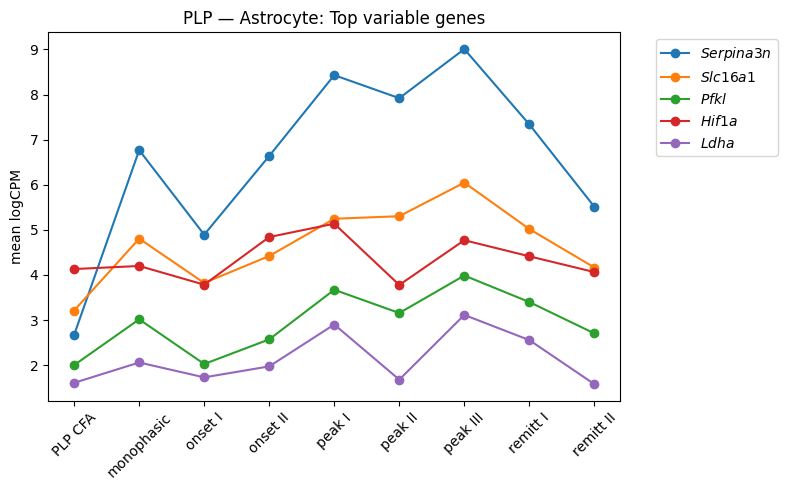

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

model = "PLP"
cm, var = variable_genes_per_model(
    adata, model_name=model, MODELS=MODELS,
    celltype="Astrocyte"
)

top_genes = var_sub.head(5).index
palette = sns.color_palette("tab10", n_colors=len(top_genes))

fig, ax = plt.subplots(figsize=(8,5))
for g, col in zip(top_genes, palette):
    ax.plot(cm.columns, cm.loc[g], marker="o", color=col, label=fr"$\it{{{g}}}$")

ax.set_ylabel("mean logCPM")
ax.set_title(f"{model} — Astrocyte: Top variable genes")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

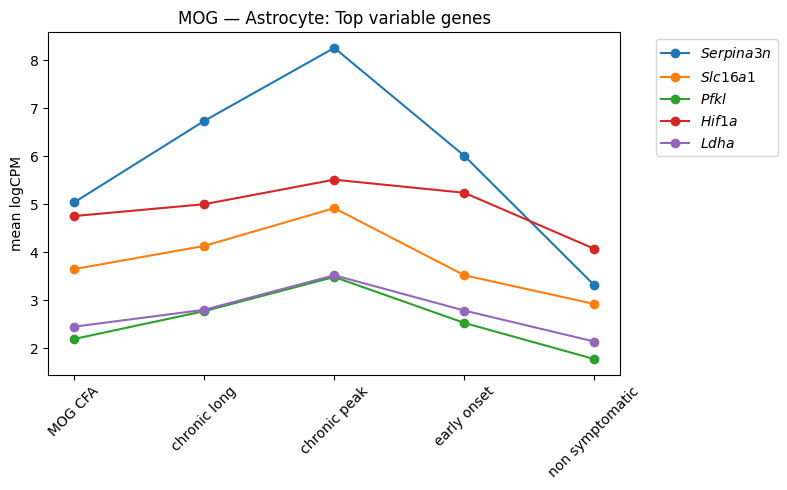

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

model = "MOG"
cm, var = variable_genes_per_model(
    adata, model_name=model, MODELS=MODELS,
    celltype="Astrocyte"
)

top_genes = var_sub.head(5).index
palette = sns.color_palette("tab10", n_colors=len(top_genes))

fig, ax = plt.subplots(figsize=(8,5))
for g, col in zip(top_genes, palette):
    ax.plot(cm.columns, cm.loc[g], marker="o", color=col, label=fr"$\it{{{g}}}$")

ax.set_ylabel("mean logCPM")
ax.set_title(f"{model} — Astrocyte: Top variable genes")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

model = "PLP"
cm, var = variable_genes_per_model(
    adata, model_name=model, MODELS=MODELS,
    celltype="Astrocyte"
)

top_genes = var.head(5).index
palette = sns.color_palette("tab10", n_colors=len(top_genes))

fig, ax = plt.subplots(figsize=(8,5))
for g, col in zip(top_genes, palette):
    ax.plot(cm.columns, cm.loc[g], marker="o", color=col, label=fr"$\it{{{g}}}$")

ax.set_ylabel("mean logCPM")
ax.set_title(f"{model} — Astrocyte: Top variable genes")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

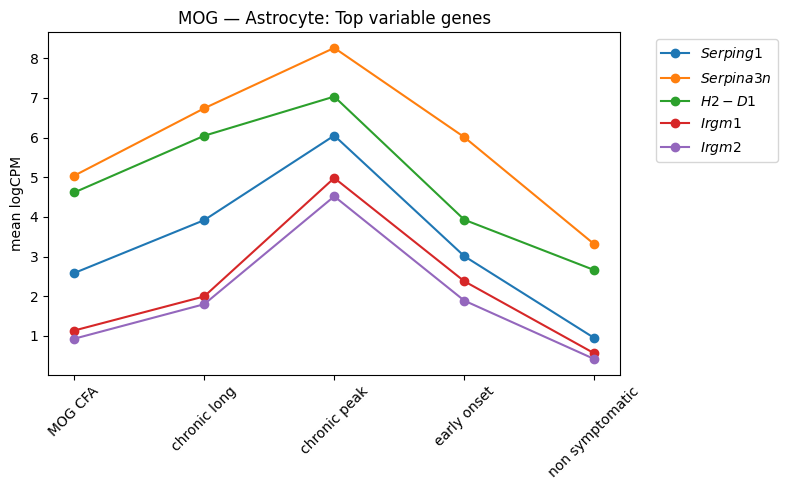

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

model = "PLP"
cm, var = variable_genes_per_model(
    adata, model_name=model, MODELS=MODELS,
    celltype="Astrocyte"
)

top_genes = var.head(5).index
palette = sns.color_palette("tab10", n_colors=len(top_genes))

fig, ax = plt.subplots(figsize=(8,5))
for g, col in zip(top_genes, palette):
    ax.plot(cm.columns, cm.loc[g], marker="o", color=col, label=fr"$\it{{{g}}}$")

ax.set_ylabel("mean logCPM")
ax.set_title(f"{model} — Astrocyte: Top variable genes")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
course_means.columns

course,MOG CFA,PLP CFA,chronic long,chronic peak,early onset,monophasic,non symptomatic,onset I,onset II,peak I,peak II,peak III,remitt I,remitt II
2610035D17Rik,0.760219,0.567049,0.684663,0.702827,0.600435,0.491483,0.641677,0.303612,0.386249,0.503658,0.420378,0.382122,0.484963,0.503577
9630013A20Rik,0.040635,0.034014,0.064848,0.105693,0.032976,0.047670,0.027849,0.026098,0.049895,0.086409,0.072568,0.058821,0.078464,0.009566
A1cf,0.001182,0.004700,0.004409,0.007733,0.003580,0.001271,0.000000,0.004661,0.003151,0.003579,0.002468,0.000658,0.004619,0.002409
A2m,5.090747,3.781237,5.922780,7.305157,5.906674,5.468080,4.578372,4.774786,4.965225,6.397564,5.945568,7.025800,5.428105,4.825909
Aatf,0.765351,0.711719,0.837476,0.785777,0.729061,0.837987,0.645680,0.717868,0.790823,0.968513,0.869408,0.959560,0.804610,0.856146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zswim9,0.242324,0.259676,0.264105,0.247415,0.219694,0.250217,0.235258,0.186908,0.249990,0.231577,0.241121,0.266640,0.257441,0.274791
Zup1,0.520665,0.338158,0.507997,0.442982,0.425951,0.342797,0.479227,0.235218,0.336152,0.374601,0.251204,0.284319,0.313890,0.355295
Zyx,0.724900,0.723223,0.928527,1.042805,0.882195,0.884206,0.577124,0.703261,0.993592,1.086883,0.734526,1.178293,0.839119,0.772139
Zzef1,1.127073,1.026866,1.124169,1.306193,1.169622,0.995753,1.033505,0.760119,1.002104,1.230116,0.939861,1.169605,1.056981,0.979196


In [8]:
variability

,var,range
Cd74,4.811892e+00,6.307446
H2-D1,4.285040e+00,5.773047
Serping1,3.851166e+00,6.077000
Serpina3n,3.560114e+00,6.332653
H2-K1,3.211678e+00,5.520392
...,...,...
Myh7,8.202805e-07,0.003130
Tbpl2,7.894877e-07,0.002742
Gsx2,6.465283e-07,0.002480
Hand1,5.580636e-07,0.001907
